In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_labels = pd.read_csv("data/labels/train_split.csv")
test_labels = pd.read_csv("data/labels/test_split.csv")
dev_labels = pd.read_csv("data/labels/dev_split.csv")

In [ ]:
train_labels = train_labels.dropna(axis = 0).reset_index(drop = True)
test_labels = test_labels.dropna(axis = 0).reset_index(drop = True)
dev_labels = dev_labels.dropna(axis = 0).reset_index(drop = True)

In [ ]:
def convert(df, df_name):
    labels = []
    for i in range(len(df)):
        temp = {}
        temp["ID"] = df.loc[i, "Participant_ID"]
        temp["Gender"] = df.loc[i, "Gender"]
        temp["Label"] = df.loc[i, "PHQ_Binary"]
        temp["Score"] = df.loc[i, "PHQ_Score"]
        temp["type"] = df_name
        labels.append(temp)
    return labels

In [ ]:
labels = []
labels = labels + convert(train_labels, "train") + convert(dev_labels, "dev") + convert(test_labels, "test")

In [ ]:
labels_df = pd.DataFrame(labels, index = None)

In [ ]:
labels_df = labels_df.sort_values("ID")
labels_df = labels_df.reset_index(drop = True)
# labels_df = labels_df.drop(columns = ["index"])

In [ ]:
def create_vocab(text, vocab, word_to_idx, idx_to_word, idx):
    for word in text.split(" "):
        if word not in vocab:
            vocab[word] = 1
            word_to_idx[word] = idx
            idx_to_word[idx] = word
            idx += 1
        else:
            vocab[word] += 1
    return vocab, word_to_idx, idx_to_word, idx

In [ ]:
df_text = []
df_text_len = []
missed = []
vocab = {}
word_to_idx = {}
idx_to_word = {}
idx = 1
for i in range(len(labels_df)):
    file = labels_df.loc[i, "ID"]
    file_name = "data/" + str(file) + "_transcript.csv"
    try:
        text_df = pd.read_csv(file_name)
        text = ""
        for i in range(1, len(text_df), 2):
            text = text + text_df.loc[i, "Start_Time,End_Time,Text,Confidence"].split(",")[2]
        text = text.lower().strip()
        vocab, word_to_idx, idx_to_word, idx = create_vocab(text, vocab, word_to_idx, idx_to_word, idx)
        df_text.append(text)
        df_text_len.append(len(text.split(" ")))
    except:
        missed.append(file)
        print(file)

In [ ]:
labels_df["text"] = df_text
labels_df["text_len"] = df_text_len
labels_df.head()

,ID,Gender,Label,Score,type,text,text_len
0,300,male,0,2,dev,interview in spanish good my parents are from ...,170
1,301,male,0,3,dev,okay i'm from los angeles i live in west los a...,704
2,302,male,0,4,train,when you're finished i'm fine how about yourse...,295
3,303,female,0,0,train,when you're finished when she's done thank you...,1049
4,304,female,0,6,train,i miss is finished can you just let me know ho...,544


In [ ]:
len(labels_df[labels_df["Label"] == 1])

12

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_path = "data/glove.6B.100d.gz"
pad = "<pad>"
pad_idx = 0

In [ ]:
word_to_idx[pad] = pad_idx
idx_to_word[pad_idx] = pad

In [ ]:
def dataset_creation(text):
    result = []
    global word_to_idx
    text = text.split(" ")
    for word in text:
        result.append(word_to_idx[word])
    return result

In [ ]:
indices = []
for i in range(len(labels_df)):
    indices.append(dataset_creation(labels_df.loc[i, "text"]))

In [ ]:
labels_df['text_to_idx'] = indices

In [ ]:
glove_w2v_file = 'data/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_path, glove_w2v_file)
glove_vec = KeyedVectors.load_word2vec_format(glove_w2v_file)

C:\Users\nsuka\AppData\Local\Temp/ipykernel_20316/1892350389.py:2: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, glove_w2v_file)


In [ ]:
weight_matrix = np.zeros((len(word_to_idx), 100), dtype = float)
embedding_dict = {}
embedding_dict[pad] = np.zeros(100, dtype = float)

In [ ]:
def create_weight_matrix(weight_matrix, model):
    global word_to_idx, embedding_dict
    for word, idx in word_to_idx.items():
#         embed = np.zeros(100, dtype = float)
        if word in embedding_dict:
            weight_matrix[idx] = embedding_dict[word]
        else:
            try:
                weight_matrix[idx] = model[word]
            except KeyError:
                rand_embed = np.random.normal(scale = 0.6, size = (100,))
                weight_matrix[idx] = rand_embed
                embedding_dict[word] = rand_embed
    
    return weight_matrix

In [ ]:
weight_matrix = create_weight_matrix(weight_matrix, glove_vec)

In [ ]:
weight_matrix.shape

(3236, 100)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels_df["text_len"].plot(kind = "hist", xlabel = None)

In [ ]:
labels_df[labels_df["Gender"] == "male"]["text_len"].plot(kind = "hist", color = "green", title = "No.of words spoken by male patients")

In [ ]:
labels_df[labels_df["Gender"] == "female"]["text_len"].plot(kind = "hist", color = "red", title = "No.of words spoken by female patients")

In [ ]:
labels_df[labels_df["Label"] == 0]["text_len"].plot(kind = "hist", color = "green", title = "No.of words spoken by non-depressed patients")

In [ ]:
labels_df[labels_df["Label"] == 1]["text_len"].plot(kind = "hist", color = "red", title = "No.of words spoken by depressed patients")

In [ ]:
labels_df[labels_df["Gender"] == "female"]["Score"].plot(kind = "hist", color = "red", title = "Depression score for female patients")

In [ ]:
labels_df[labels_df["Gender"] == "male"]["Score"].plot(kind = "hist", color = "green", title = "Depression score for male patients")

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
vocab_updated = {}
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for word in list(vocab.keys()):
    word = word.lower()
    stem = stemmer.stem(word)
    lemma = lemmatizer.lemmatize(word)
    if word not in stop_words and stem not in stop_words and lemma not in stop_words:
        vocab_updated[word] = vocab[word]

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
stopwords = set(STOPWORDS)

In [ ]:
depressed_text = " ".join(text for text in labels_df[labels_df["Label"] == 1]["text"])

In [ ]:
non_depressed_text = " ".join(text for text in labels_df[labels_df["Label"] == 0]["text"])

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(depressed_text)

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(non_depressed_text)

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
lengths = []
for text in labels_df["text"]:
    temp = 0
    for word in text.split(" "):
        word = word.lower()
        stem = stemmer.stem(word)
        lemma = lemmatizer.lemmatize(word)
        if word not in stop_words and stem not in stop_words and lemma not in stop_words:
            temp += 1
    lengths.append(temp)

In [ ]:
labels_df["text_len_no_stopwords"] = lengths

In [ ]:
labels_df.head()

,ID,Gender,Label,Score,type,text,text_len,text_to_idx,text_len_no_stopwords
0,300,male,0,2,dev,interview in spanish good my parents are from ...,170,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 10...",85
1,301,male,0,3,dev,okay i'm from los angeles i live in west los a...,704,"[113, 23, 8, 114, 115, 10, 116, 2, 117, 114, 1...",324
2,306,female,0,0,dev,all right it's taking its time okay. and then ...,1048,"[75, 27, 74, 59, 294, 295, 296, 21, 58, 124, 9...",467
3,317,male,0,8,dev,okay how was are you okay i'm okay a little sl...,268,"[113, 100, 84, 7, 91, 113, 23, 113, 25, 224, 5...",136
4,320,female,0,11,dev,and okay and then i will let you know okay now...,366,"[21, 113, 21, 58, 10, 418, 179, 91, 92, 113, 2...",163


In [ ]:
import torch
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
batch_size = 64

In [ ]:
train_data = []
val_data = []
test_data = []
train_labels = []
val_labels = []
test_labels = []
train_score = []
val_score = []
test_score = []

In [ ]:
labels_df

,ID,Gender,Label,Score,type,text,text_len
0,300,male,0,2,dev,interview in spanish good my parents are from ...,170
1,301,male,0,3,dev,okay i'm from los angeles i live in west los a...,704
2,302,male,0,4,train,when you're finished i'm fine how about yourse...,295
3,303,female,0,0,train,when you're finished when she's done thank you...,1049
4,304,female,0,6,train,i miss is finished can you just let me know ho...,544
...,...,...,...,...,...,...,...
268,713,male,0,0,dev,oh that's the one that was at the front desk o...,335
269,715,male,0,7,test,okay okay and please okay so so the beach shop...,964
270,716,male,1,15,test,for real i'm not a therapist okay inland empir...,598
271,717,male,0,1,test,once again after she says goodbye go ahead and...,731


In [ ]:
for i in range(len(labels_df)):
    if labels_df.loc[i, "type"] == "train":
#         train_data.append(np.array(labels_df.loc[i, "text_to_idx"]))
        train_labels.append(labels_df.loc[i, "Label"])
        train_score.append(float(labels_df.loc[i, "Score"]))
    elif labels_df.loc[i, "type"] == "dev":
#         val_data.append(np.array(labels_df.loc[i, "text_to_idx"]))
        val_labels.append(labels_df.loc[i, "Label"])
        val_score.append(float(labels_df.loc[i, "Score"]))
    else:
#         test_data.append(np.array(labels_df.loc[i, "text_to_idx"]))
        test_labels.append(labels_df.loc[i, "Label"])
        test_score.append(float(labels_df.loc[i, "Score"]))

In [ ]:
train_data = np.array(train_data)
val_data = np.array(val_data)
test_data = np.array(test_data)

C:\Users\nsuka\AppData\Local\Temp/ipykernel_20316/1862688367.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  val_data = np.array(val_data)


In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

train_score = np.array(train_score)
val_score = np.array(val_score)
test_score = np.array(test_score)

# scaler = MinMaxScaler()
# train_score = np.expand_dims(np.array(train_score), axis = 1)
# val_score = np.expand_dims(np.array(val_score), axis = 1)
# test_score = np.expand_dims(np.array(test_score), axis = 1)

# train_score = scaler.fit_transform(np.array(train_score))
# val_score = scaler.transform(np.array(val_score))
# test_score = scaler.transform(np.array(test_score))

In [ ]:
class PadSequence:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.LongTensor(x[0]) for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
        lengths = torch.LongTensor([len(x) for x in sequences])
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return torch.LongTensor(sequences_padded), torch.LongTensor(labels), lengths

In [ ]:
train_dataset = list(zip(train_data, train_labels))
val_dataset = list(zip(val_data, val_labels))
test_dataset = list(zip(test_data, test_labels))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence())
val_loader = DataLoader(val_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence())
test_loader = DataLoader(test_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence())

In [ ]:
input_dim = len(word_to_idx)
embed_dim = 100
hidden_dim = 256
linear_dim = 128
output_dim = 2

In [ ]:
def create_embedding(input_dim, embed_dim, pad_idx, weight_matrix):
    weight_matrix = torch.FloatTensor(weight_matrix).to(device)
    embedding = torch.nn.Embedding(num_embeddings = input_dim, embedding_dim = embed_dim, padding_idx = pad_idx)
    embedding.load_state_dict({'weight': weight_matrix})
    return embedding

In [ ]:
def accuracy(pred, targ):
    pred = pred.argmax(dim = 1, keepdim = True)
    correct = pred.squeeze(1).eq(targ)
    return correct.sum() / torch.FloatTensor([targ.shape[0]]).to(device)

In [ ]:
class glove_GRU(torch.nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, linear_dim, output_dim, pad_idx, weight_matrix):
        super(glove_GRU, self).__init__()
        self.pad_idx = pad_idx
        self.linear_dim = linear_dim
        self.embedding = create_embedding(input_dim, embed_dim, pad_idx, weight_matrix)
        self.gru = torch.nn.GRU(input_size = embed_dim, hidden_size = hidden_dim, num_layers = 1, bidirectional = False, batch_first = True)
#         self.dropout = torch.nn.Dropout(p = 0.33)
        self.linear = torch.nn.Linear(hidden_dim, linear_dim)
        self.relu = torch.nn.ReLU()
        self.classifier = torch.nn.Linear(linear_dim, output_dim)
    
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = True)
        gru_out, h_t = self.gru(packed)
#         gru_out = self.dropout(gru_out[:, -1])
#         gru_out = gru_out[:, -1]
        lin_out = self.linear(h_t[-1])
        class_out = self.classifier(lin_out)
        return class_out
    
    def init_weights(self):
        for name, param in self.named_parameters():
            torch.nn.init.normal_(param.data, mean=0, std=0.1)

In [ ]:
model = glove_GRU(input_dim, embed_dim, hidden_dim, linear_dim, output_dim, pad_idx, weight_matrix).to(device)
# model.init_weights()
print(model)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights[1] = 1.05 * class_weights[1]
class_weights

In [ ]:
class_weights = torch.FloatTensor(class_weights)
loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# scheduler = StepLR(optimizer, step_size = 25) 

In [ ]:
epochs = 20
dev_max_acc = 0
for epoch in range(epochs):
    model.train()
    train_acc = 0.0
    dev_acc = 0.0
    batch = 0
    for inputs, target, lens in train_loader:
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_acc += float(accuracy(output, target).item())
    model.eval()
    for inputs, target, lens in val_loader:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        loss = loss_fn(output, target)
        dev_acc += float(accuracy(output, target).item())
    
    train_acc = (train_acc * batch_size)/len(train_loader.dataset)
    dev_acc = (dev_acc * batch_size)/len(val_loader.dataset)
    
    print('Epoch: {} \tTraining Acc: {:.6f} \tDev Set Acc: {:.6f}'.format(epoch+1, train_acc,dev_acc))
    if dev_acc >= dev_max_acc:
        print('Dev Set acc increased ({:.6f} --> {:.6f}). Saving model...'.format(dev_max_acc, dev_acc))
        torch.save(model.state_dict(), 'model/text_GRU_alternate.pt')
        dev_max_acc = dev_acc 

In [ ]:
del model, optimizer, loss_fn

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred,
                       sample_weight=None,
                       multioutput='uniform_average'):
    cor=np.corrcoef(y_true,y_pred)[0][1]
#     print("Corrcoef: ", cor)
    mean_true=np.mean(y_true)
#     print("Target mean: ", mean_true)
    mean_pred=np.mean(y_pred)
#     print("Pred mean: ", mean_pred)
    var_true=np.var(y_true)
    var_pred=np.var(y_pred)
    
    sd_true=np.std(y_true)
#     print("Target std: ", sd_true)
    sd_pred=np.std(y_pred)
#     print("Pred std: ", sd_pred)
#     print("Value: ", 2 * cor * sd_true * sd_pred)
    numerator=2*cor*sd_true*sd_pred
    
    denominator=var_true+var_pred+(mean_true-mean_pred)**2
#     print("Num: ", numerator, "\nDenom: ", denominator)
    return numerator/denominator


In [ ]:
model = glove_GRU(input_dim, embed_dim, hidden_dim, linear_dim, output_dim, pad_idx, weight_matrix).to(device)
model.load_state_dict(torch.load("model/text_GRU_alternate.pt"))

model.eval()
targets = None
preds = None
with torch.no_grad():
    for inputs, target, lens in test_loader:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        _, pred = torch.max(output, 1)
#         print(target.shape, pred.shape)
        if targets == None:
            targets = target
            preds = pred
        else:
            targets = torch.cat((targets, target), 0)
            preds = torch.cat((preds, pred), 0)
targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
print("F1: ", f1_score(targets, preds, average = "macro"))
print("Accuracy: ", accuracy_score(targets, preds))
# print("CCC: ", concordance_correlation_coefficient(targets, preds))
cm = confusion_matrix(targets, preds)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_labels))
cmd_obj.plot()
cmd_obj.ax_.set(title='Confusion Matrix', xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

del model

In [ ]:
batch_size = 32

In [ ]:
class PadSequence_regression:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.LongTensor(x[0]) for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
        lengths = torch.LongTensor([len(x) for x in sequences])
        scores = torch.FloatTensor([x[1] for x in sorted_batch])
        return torch.LongTensor(sequences_padded), torch.FloatTensor(scores), lengths

In [ ]:
train_dataset_reg = list(zip(train_data, train_score))
val_dataset_reg = list(zip(val_data, val_score))
test_dataset_reg = list(zip(test_data, test_score))

In [ ]:
train_loader_reg = DataLoader(train_dataset_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression())
val_loader_reg = DataLoader(val_dataset_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression())
test_loader_reg = DataLoader(test_dataset_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression())

In [ ]:
input_dim = len(word_to_idx)
embed_dim = 100
hidden_dim = 256
linear_dim_1 = 128
linear_dim_2 = linear_dim_1 // 2
# linear_dim_3 = linear_dim_2

In [ ]:
max_split_size_mb = 128

PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb

In [ ]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

In [ ]:
class glove_GRU_regression(torch.nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, linear_dim_1, linear_dim_2, pad_idx, weight_matrix):
        super(glove_GRU_regression, self).__init__()
        self.pad_idx = pad_idx
#         self.linear_dim = linear_dim
        self.embedding = create_embedding(input_dim, embed_dim, pad_idx, weight_matrix)
        self.gru = torch.nn.GRU(input_size = embed_dim, hidden_size = hidden_dim, num_layers = 2, bidirectional = False, batch_first = True, dropout = 0)
        self.dropout = torch.nn.Dropout(p = 0)
        self.linear_1 = torch.nn.Linear(hidden_dim, linear_dim_1)
        self.linear_2 = torch.nn.Linear(linear_dim_1, linear_dim_2)
#         self.linear_3 = torch.nn.Linear(linear_dim_2, linear_dim_3)
#         self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(linear_dim_2, 1)
    
    def forward(self, x, lengths):
        emb = self.embedding(x)
#         packed = pack_padded_sequence(emb, lengths, batch_first = True, enforce_sorted = True)
        gru_out, h_t = self.gru(emb)
#         gru_out = self.dropout(gru_out[:, -1])
        gru_out = gru_out[:, -1, :]
        lin_out_1 = self.dropout(self.linear_1(self.dropout(gru_out)))
        lin_out_2 = self.dropout(self.linear_2(lin_out_1))
#         lin_out_3 = self.dropout(self.linear_3(lin_out_2))
        out = self.output(lin_out_2)
        return out

In [ ]:
model = glove_GRU_regression(input_dim, embed_dim, hidden_dim, linear_dim_1, linear_dim_2, pad_idx, weight_matrix).to(device)
# model.init_weights()
print(model)

In [ ]:
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-6)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=- 1, verbose=True)

In [ ]:
epochs = 30
dev_min_loss = np.inf
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    dev_loss = 0.0
    batch = 0
    for inputs, target, lens in train_loader_reg:
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    for inputs, target, lens in val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        dev_loss += loss.item()
    
    train_loss = train_loss / len(train_loader_reg)
    dev_loss = dev_loss / len(val_loader_reg)
#     scheduler.step()
    print('Epoch: {} \tTraining Loss: {:.6f} \tDev Set Loss: {:.6f}'.format(epoch+1, train_loss,dev_loss))
    if dev_loss <= dev_min_loss:
        print('Dev Set Loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(dev_min_loss, dev_loss))
        torch.save(model.state_dict(), 'model/text_GRU_reg_alternate.pt')
        dev_min_loss = dev_loss 

In [ ]:
del model, loss_fn, optimizer

In [ ]:
model = glove_GRU_regression(input_dim, embed_dim, hidden_dim, linear_dim_1, linear_dim_2, pad_idx, weight_matrix).to(device)
model.load_state_dict(torch.load("model/text_GRU_reg_alternate.pt"))
model.eval()
targets = None
with torch.no_grad():
    for inputs, target, lens in test_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs, lens)
        pred = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        if targets == None:
            targets = target
            preds = pred
        else:
            targets = torch.cat((targets, target), 0)
            preds = torch.cat((preds, pred), 0)
targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
# targets = scaler.inverse_transform(np.expand_dims(targets, axis = 1))
# preds = scaler.inverse_transform(np.expand_dims(preds, axis = 1))
targets = np.expand_dims(targets, axis = 1)
preds = np.expand_dims(preds, axis = 1)
print("RMSE Score: ", mean_squared_error(targets, preds, squared = False))
targets, preds = np.squeeze(targets), np.squeeze(preds)
# print("Accuracy: ", accuracy_score(targets, preds))
print("CCC: ", concordance_correlation_coefficient(targets, preds))
# cm = confusion_matrix(targets, preds)
# cmd_obj = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_labels))
# cmd_obj.plot()
# cmd_obj.ax_.set(title='Confusion Matrix', xlabel='Predicted Labels', ylabel='True Labels')
# plt.show()
# print("\n", targets)
# print(preds)
print()
del model

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
transformer = SentenceTransformer("all-mpnet-base-v2", device = 'cuda')

In [ ]:
def create_tranformer_dataset(transcript, model):
    encoding = []
    for i in range(1, len(transcript), 2):
        encoding.append(model.encode(transcript.loc[i, "Start_Time,End_Time,Text,Confidence"].split(",")[2]))
    return np.array(encoding)

In [ ]:
sbert_train = []
sbert_val = []
sbert_test = []
for i in range(len(labels_df)):
    file = labels_df.loc[i, "ID"]
    file_name = "data/" + str(file) + "_transcript.csv"
    df = pd.read_csv(file_name)
    data = create_tranformer_dataset(df, transformer)
    if labels_df.loc[i, "type"] == "train":
        sbert_train.append(data)
    elif labels_df.loc[i, "type"] == "dev":
        sbert_val.append(data)
    else:
        sbert_test.append(data) 

In [ ]:
class PadSequence_sbert:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.FloatTensor(x[0]) for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0.0)
        lengths = torch.LongTensor([len(x) for x in sequences])
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return torch.FloatTensor(sequences_padded), torch.LongTensor(labels), lengths

In [ ]:
sbert_train, sbert_val, sbert_test = np.array(sbert_train), np.array(sbert_val), np.array(sbert_test)

C:\Users\nsuka\AppData\Local\Temp/ipykernel_20316/2266321980.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sbert_train, sbert_val, sbert_test = np.array(sbert_train), np.array(sbert_val), np.array(sbert_test)


In [ ]:
sbert_train_dataset = list(zip(sbert_train, train_labels))
sbert_val_dataset = list(zip(sbert_val, val_labels))
sbert_test_dataset = list(zip(sbert_test, test_labels))

In [ ]:
batch_size = 64

In [ ]:
sbert_train_loader = DataLoader(sbert_train_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_sbert())
sbert_val_loader = DataLoader(sbert_val_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_sbert())
sbert_test_loader = DataLoader(sbert_test_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_sbert())

In [ ]:
class sbert_GRU(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, linear_dim, output_dim):
        super(sbert_GRU, self).__init__()
        self.linear_dim = linear_dim
        self.gru = torch.nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = 1, bidirectional = False, batch_first = True)
        self.dropout = torch.nn.Dropout(p = 0.33)
        self.linear = torch.nn.Linear(hidden_dim, linear_dim)
        self.relu = torch.nn.ReLU()
        self.classifier = torch.nn.Linear(linear_dim, output_dim)
    
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = True)
        gru_out, h_t = self.gru(packed)
#         gru_out = self.dropout(gru_out[:, -1])
#         gru_out = gru_out[:, -1]
        lin_out = self.linear(h_t[-1])
        class_out = self.classifier(lin_out)
        return class_out
    
    def init_weights(self):
        for name, param in self.named_parameters():
            torch.nn.init.normal_(param.data, mean=0, std=0.1)

In [ ]:
input_dim = 768
hidden_dim = 1024
linear_dim = 512
output_dim = 2

In [ ]:
model = sbert_GRU(input_dim, hidden_dim, linear_dim, output_dim).to(device)
# model.init_weights()
print(model)

sbert_GRU(
  (gru): GRU(768, 1024, batch_first=True)
  (dropout): Dropout(p=0.33, inplace=False)
  (linear): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights[1] = 1.7 * class_weights[1]
class_weights

array([0.6468254 , 3.74459459])

In [ ]:
class_weights = torch.FloatTensor(class_weights)
loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
len(sbert_train_dataset)/batch_size

2.546875

In [ ]:
epochs = 30
dev_max_acc = 0
for epoch in range(epochs):
    model.train()
    train_acc = 0.0
    dev_acc = 0.0
    batch = 0
    count = 0
    for inputs, target, lens in sbert_train_loader:
        
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_acc += float(accuracy(output, target).item())
    model.eval()
    for inputs, target, lens in sbert_val_loader:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        loss = loss_fn(output, target)
        dev_acc += float(accuracy(output, target).item())
    
    train_acc = train_acc / ((len(sbert_train_loader.dataset) / batch_size) + 1)
    dev_acc = dev_acc / ((len(sbert_val_loader.dataset) / batch_size) + 1)
    
    print('Epoch: {} \tTraining Acc: {:.6f} \tDev Set Acc: {:.6f}'.format(epoch+1, train_acc,dev_acc))
    if dev_acc >= dev_max_acc:
        print('Dev Set acc increased ({:.6f} --> {:.6f}). Saving model...'.format(dev_max_acc, dev_acc))
        torch.save(model.state_dict(), 'model/sbert_GRU.pt')
        dev_max_acc = dev_acc 

NameError: name 'accuracy' is not defined

In [ ]:
del model, loss_fn, optimizer

F1:  0.6588628762541806
Accuracy:  0.6851851851851852


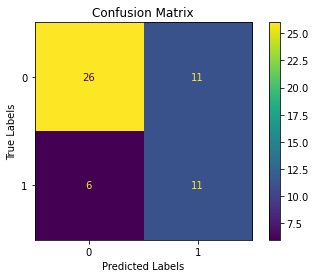

In [ ]:
model = sbert_GRU(input_dim, hidden_dim, linear_dim, output_dim).to(device)
model.load_state_dict(torch.load("model/sbert_GRU.pt"))

model.eval()
targets = None
preds = None
with torch.no_grad():
    for inputs, target, lens in sbert_test_loader:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs, lens)
        output = output.view(-1, output.shape[-1])
        target = target.view(-1)
        _, pred = torch.max(output, 1)
#         print(target.shape, pred.shape)
        if targets == None:
            targets = target
            preds = pred
        else:
            targets = torch.cat((targets, target), 0)
            preds = torch.cat((preds, pred), 0)
targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
print("F1: ", f1_score(targets, preds, average = "macro"))
print("Accuracy: ", accuracy_score(targets, preds))
# print("CCC: ", concordance_correlation_coefficient(targets, preds))
cm = confusion_matrix(targets, preds)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_labels))
cmd_obj.plot()
cmd_obj.ax_.set(title='Confusion Matrix', xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

del model

In [ ]:
class PadSequence_regression_bert:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.FloatTensor(x[0]) for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
        lengths = torch.FloatTensor([len(x) for x in sequences])
        scores = torch.FloatTensor([x[1] for x in sorted_batch])
        return torch.FloatTensor(sequences_padded), torch.FloatTensor(scores), lengths

In [ ]:
sbert_train_reg = list(zip(sbert_train, train_score))
sbert_val_reg = list(zip(sbert_val, val_score))
sbert_test_reg = list(zip(sbert_test, test_score))

In [ ]:
batch_size = 4

In [ ]:
sbert_train_loader_reg = DataLoader(sbert_train_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())
sbert_val_loader_reg = DataLoader(sbert_val_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())
sbert_test_loader_reg = DataLoader(sbert_test_reg, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())

In [ ]:
class sbert_GRU_regression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, linear_dim_1, linear_dim_2):
        super(sbert_GRU_regression, self).__init__()
        self.pad_idx = pad_idx
#         self.linear_dim = linear_dim
        self.gru = torch.nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = 1, bidirectional = False, batch_first = True, dropout = 0)
        self.dropout = torch.nn.Dropout(p = 0)
        self.linear_1 = torch.nn.Linear(hidden_dim, linear_dim_1)
#         self.linear_2 = torch.nn.Linear(linear_dim_1, linear_dim_2)
#         self.linear_3 = torch.nn.Linear(linear_dim_2, linear_dim_3)
#         self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(linear_dim_1, 1)
    
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = True)
        gru_out, h_t = self.gru(packed)
#         print(h_t.shape)
#         print(h_t[-1, :, :].shape)
#         gru_out = self.dropout(gru_out[:, -1])
#         gru_out = gru_out[:, -1, :]
#         h_t = h_t[-1, :, :]
        lin_out_1 = self.dropout(self.linear_1(self.dropout(h_t[-1])))
#         lin_out_2 = self.dropout(self.linear_2(lin_out_1))
#         lin_out_3 = self.dropout(self.linear_3(lin_out_2))
        out = self.output(lin_out_1)
        return out

In [ ]:
input_dim = 768
hidden_dim = 1024
linear_dim_1 = 512
linear_dim_2 = linear_dim // 2

model = sbert_GRU_regression(input_dim, hidden_dim, linear_dim_1, linear_dim_2).to(device)
# model.init_weights()
print(model)

In [ ]:
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-6)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9, last_epoch=- 1, verbose=True)

In [ ]:
epochs = 20
dev_min_loss = np.inf
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    dev_loss = 0.0
    batch = 0
    for inputs, target, lens in sbert_train_loader_reg:
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    for inputs, target, lens in sbert_val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        dev_loss += loss.item()
    
    train_loss = train_loss / len(sbert_train_loader_reg)
    dev_loss = dev_loss / len(sbert_val_loader_reg)
#     scheduler.step()
    print('Epoch: {} \tTraining Loss: {:.6f} \tDev Set Loss: {:.6f}'.format(epoch+1, train_loss,dev_loss))
    if dev_loss <= dev_min_loss:
        print('Dev Set Loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(dev_min_loss, dev_loss))
        torch.save(model.state_dict(), 'model/sbert_GRU_reg.pt')
        dev_min_loss = dev_loss 

In [ ]:
del model, loss_fn, optimizer

In [ ]:
model = sbert_GRU_regression(input_dim, hidden_dim, linear_dim_1, linear_dim_2).to(device)
model.load_state_dict(torch.load("model/sbert_GRU_reg.pt"))
model.eval()
if batch_size == 1:
    targets = []
    preds = []
else:
    targets = None
with torch.no_grad():
    for inputs, target, lens in sbert_test_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs, lens)
        pred = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        if batch_size == 1:
            targets.append(target.item())
            preds.append(pred.item())
        else:
            if targets == None:
                targets = target
                preds = pred
            else:
                targets = torch.cat((targets, target), 0)
                preds = torch.cat((preds, pred), 0)
if batch_size == 1:
    targets = np.expand_dims(np.array(targets), axis = 1)
    preds = np.expand_dims(np.array(preds), axis = 1)
else:
    targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
    # targets = scaler.inverse_transform(np.expand_dims(targets, axis = 1))
    # preds = scaler.inverse_transform(np.expand_dims(preds, axis = 1))
    targets = np.expand_dims(targets, axis = 1)
    preds = np.expand_dims(preds, axis = 1)
print("Target:", targets)
print("Preds:", preds)
print("RMSE Score: ", mean_squared_error(targets, preds, squared = False))
targets, preds = np.squeeze(targets), np.squeeze(preds)
# print("Accuracy: ", accuracy_score(targets, preds))
print("CCC: ", concordance_correlation_coefficient(targets, preds))
# cm = confusion_matrix(targets, preds)
# cmd_obj = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_labels))
# cmd_obj.plot()
# cmd_obj.ax_.set(title='Confusion Matrix', xlabel='Predicted Labels', ylabel='True Labels')
# plt.show()
# print("\n", targets)
# print(preds)
print()
del model

Target: [[19.]
 [15.]
 [ 3.]
 [13.]
 [ 0.]
 [ 4.]
 [16.]
 [ 0.]
 [ 0.]
 [ 7.]
 [ 7.]
 [ 5.]
 [15.]
 [ 1.]
 [16.]
 [ 7.]
 [19.]
 [ 5.]
 [ 5.]
 [ 3.]
 [ 7.]
 [11.]
 [11.]
 [ 9.]
 [ 2.]
 [ 0.]
 [17.]
 [ 0.]
 [ 9.]
 [ 0.]
 [12.]
 [ 6.]
 [13.]
 [22.]
 [20.]
 [ 8.]
 [13.]
 [ 2.]
 [ 5.]
 [ 2.]
 [ 3.]
 [10.]
 [ 0.]
 [ 2.]
 [16.]
 [ 3.]
 [ 0.]
 [19.]
 [ 8.]
 [12.]
 [ 9.]
 [ 0.]
 [19.]
 [12.]]
Preds: [[14.124115 ]
 [15.636131 ]
 [ 4.217386 ]
 [ 5.995835 ]
 [ 8.62693  ]
 [ 4.446741 ]
 [ 7.5090814]
 [ 4.021942 ]
 [ 6.510285 ]
 [12.22932  ]
 [ 6.262854 ]
 [ 7.5575414]
 [16.904139 ]
 [ 4.6930003]
 [10.00125  ]
 [ 7.061578 ]
 [14.868844 ]
 [ 6.4085536]
 [ 9.062409 ]
 [ 2.523838 ]
 [ 3.5907586]
 [ 9.590245 ]
 [15.1033   ]
 [ 6.0128093]
 [ 5.6329784]
 [ 4.2733603]
 [ 4.602468 ]
 [ 6.484957 ]
 [ 7.7310977]
 [ 6.7098894]
 [11.292905 ]
 [ 2.2600782]
 [12.660085 ]
 [13.822804 ]
 [11.573426 ]
 [ 4.449501 ]
 [ 5.1349435]
 [ 1.5263994]
 [ 2.6154904]
 [ 2.6298807]
 [ 5.2742133]
 [ 6.294449 ]
 [ 4.470383 ]
 [ 3

In [ ]:
train_labels = pd.read_csv("Fusion/train_split.csv")
dev_labels = pd.read_csv("Fusion/dev_split.csv")

In [ ]:
train_labels.drop(columns=["Gender", "PCL-C (PTSD)", "PTSD Severity"], inplace=True)
dev_labels.drop(columns=["Gender", "PCL-C (PTSD)", "PTSD Severity"], inplace=True)

In [ ]:
train_labels

In [ ]:
egemaps_data = {}
ege_df = pd.read_pickle("Fusion\egemaps_df_padd.pkl")

In [ ]:
ege_df.drop(columns=['Unnamed: 0', 'name', 'frameTime'], inplace=True)

In [ ]:
ege_df["patient_id"].unique()

In [ ]:
for i in range(len)

In [ ]:
SEQ_LENGTH=20*60*100

In [ ]:
ege_train = {}
ege_dev = {}
train_idx = 0
dev_idx = 0
for idx in egemaps_data:
    print(idx)
    if egemaps_data[idx]["id"] in train_labels["Participant_ID"].values:
        ege_train[train_idx] = egemaps_data[idx]
        train_idx += 1
    else:
        ege_dev[dev_idx] = egemaps_data[idx]
        dev_idx += 1

In [ ]:
ege_train = {}
ege_dev = {}

for i in range(0, len(ege_df), 120000):
    print(i, end = "\r")
    pid = ege_df.iloc[i]["patient_id"]
    if pid in train_labels["Participant_ID"].values:
        ege_train[pid] = ege_df.iloc[i:i+120000].drop(['Unnamed: 0', 'name', 'frameTime', 'patient_id', 'bin','req'], axis = 1).values
    else:
        ege_dev[pid] = ege_df.iloc[i:i+120000].drop(['Unnamed: 0', 'name', 'frameTime', 'patient_id', 'bin','req'], axis = 1).values

In [ ]:
ege_train = dict(sorted(ege_train.items()))
ege_dev = dict(sorted(ege_dev.items()))

In [ ]:
ege_train_data = []
ege_dev_data = []
for key in ege_train:
    ege_train_data.append(ege_train[key])
for key in ege_dev:
    ege_dev_data.append(ege_dev[key])
ege_train_data = np.array(ege_train_data)
ege_dev_data = np.array(ege_dev_data)

In [ ]:
ege_dev_data.shape

(56, 120000, 23)

In [ ]:
import pickle as pkl
with open("ege_train.pkl", "wb") as fp:
    pkl.dump(ege_train_data, fp)
    
with open("ege_dev.pkl", "wb") as fp:
    pkl.dump(ege_dev_data, fp)

In [ ]:
from torch.nn.functional import interpolate as interpolate
def create_fusion_data(sbert_data, ege_data):
    fusion_data = []
    ege_down = []
    for sbert, ege in zip(sbert_data, ege_data):
        sbert = torch.FloatTensor(sbert)
        ege = torch.FloatTensor(ege)
        ratio = len(sbert)
        sbert_t = sbert.T[None, :]
        ege_t = ege.T[None, :]
        ege_t = interpolate(ege_t, size = [len(sbert)])
        sbert = sbert_t[0, :].T
        ege = ege_t[0, :].T
        fusion = torch.cat((sbert, ege), dim = 1).cpu().detach().numpy()
        fusion_data.append(fusion)
        ege_down.append(ege)
    return ege_down, sbert, fusion_data

In [ ]:
ege_train, _, fusion_train = create_fusion_data(sbert_train, ege_train_data)

In [ ]:
ege_val, _, fusion_val = create_fusion_data(sbert_val, ege_dev_data)

In [ ]:
ege_train_dataset = list(zip(ege_train, train_score))
ege_val_dataset = list(zip(ege_val, val_score))

In [ ]:
class PadSequence_regression_bert:
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        sequences = [torch.FloatTensor(x[0]) for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
        lengths = torch.FloatTensor([len(x) for x in sequences])
        scores = torch.FloatTensor([x[1] for x in sorted_batch])
        return torch.FloatTensor(sequences_padded), torch.FloatTensor(scores), lengths

In [ ]:
batch_size = 2

In [ ]:
ege_train_loader_reg = DataLoader(ege_train_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())
ege_val_loader_reg = DataLoader(ege_val_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())

In [ ]:
train_on_gpu=torch.cuda.is_available()

In [ ]:
class ege_GRU_regression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, linear_dim, linear_dim_2, n_layers, output_size, drop_prob):
        super(ege_GRU_regression, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.linear_dim = linear_dim
        self.linear_dim_2 = linear_dim_2
        self.drop_prob=drop_prob
        self.dropout = torch.nn.Dropout(p=self.drop_prob)

        self.output_size = output_size
        
        
        self.gru = torch.nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        

        self.linear = torch.nn.Linear(self.hidden_dim, self.linear_dim)
        self.linear_2 = torch.nn.Linear(self.linear_dim, self.linear_dim_2)
        self.fc = torch.nn.Linear(self.linear_dim_2, self.output_size)
#         self.RELU = torch.nn.ReLU()
    
    def forward(self, x, lengths):
        #x = x.long()
        packed = pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = True)
        gru_out, h_t = self.gru(packed)
        #print(lstm_out)
        # getting the last time step output
        
        h_out = h_t[-1]
        linear = self.dropout(self.linear(h_out))
        linear_2 = self.dropout(self.linear_2(linear))
        #print("LSTM_out",out)
        out = self.fc(linear_2)
        #print(out)
#         out = self.RELU(out)
        #out = self.sig(out)
        
        return out

In [ ]:
input_dim = 23
hidden_dim = 256
linear_dim = 128
linear_dim_2 = linear_dim // 2
n_layers = 2
output_size = 1
drop_prob=0.2

In [ ]:
model = ege_GRU_regression(input_dim, hidden_dim, linear_dim, linear_dim_2, n_layers, output_size, drop_prob).to(device)
print(model)

ege_GRU_regression(
  (dropout): Dropout(p=0.2, inplace=False)
  (gru): GRU(23, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-6)

In [ ]:
epochs = 20
dev_min_loss = np.inf
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    dev_loss = 0.0
    batch = 0
    for inputs, target, lens in ege_train_loader_reg:
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    for inputs, target, lens in ege_val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        with torch.no_grad():
            output = model(inputs, lens)
            output = torch.squeeze(output.view(-1, output.shape[-1]))
            target = target.view(-1)
            loss = torch.sqrt(loss_fn(output, target))
            dev_loss += loss.item()
    
    train_loss = train_loss / len(ege_train_loader_reg)
    dev_loss = dev_loss / len(ege_val_loader_reg)
#     scheduler.step()
    print('Epoch: {} \tTraining Loss: {:.6f} \tDev Set Loss: {:.6f}'.format(epoch+1, train_loss,dev_loss))
    if dev_loss <= dev_min_loss:
        print('Dev Set Loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(dev_min_loss, dev_loss))
        torch.save(model.state_dict(), 'model/ege_reg.pt')
        dev_min_loss = dev_loss 

Epoch: 1 	Training Loss: 6.286361 	Dev Set Loss: 5.206619
Dev Set Loss decreased (inf --> 5.206619). Saving model...


C:\Users\nsuka\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 2 	Training Loss: 5.549934 	Dev Set Loss: 5.198922
Dev Set Loss decreased (5.206619 --> 5.198922). Saving model...
Epoch: 3 	Training Loss: 5.328710 	Dev Set Loss: 5.081283
Dev Set Loss decreased (5.198922 --> 5.081283). Saving model...
Epoch: 4 	Training Loss: 5.496516 	Dev Set Loss: 5.099389
Epoch: 5 	Training Loss: 5.542003 	Dev Set Loss: 5.199020
Epoch: 6 	Training Loss: 5.512590 	Dev Set Loss: 5.118595
Epoch: 7 	Training Loss: 5.526781 	Dev Set Loss: 5.099550
Epoch: 8 	Training Loss: 5.402089 	Dev Set Loss: 5.091760
Epoch: 9 	Training Loss: 5.435784 	Dev Set Loss: 5.137089
Epoch: 10 	Training Loss: 5.403621 	Dev Set Loss: 5.093310
Epoch: 11 	Training Loss: 5.494804 	Dev Set Loss: 5.119507
Epoch: 12 	Training Loss: 5.430522 	Dev Set Loss: 5.089976
Epoch: 13 	Training Loss: 5.332207 	Dev Set Loss: 4.925551
Dev Set Loss decreased (5.081283 --> 4.925551). Saving model...
Epoch: 14 	Training Loss: 5.389719 	Dev Set Loss: 5.009062
Epoch: 15 	Training Loss: 5.468251 	Dev Set Loss:

In [ ]:
del model, loss_fn, optimizer

In [ ]:
model = ege_GRU_regression(input_dim, hidden_dim, linear_dim, linear_dim_2, n_layers, output_size, drop_prob).to(device)
model.load_state_dict(torch.load("model/ege_reg.pt"))
model.eval()
if batch_size == 1:
    targets = []
    preds = []
else:
    targets = None
with torch.no_grad():
    for inputs, target, lens in ege_val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs, lens)
        pred = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        if batch_size == 1:
            targets.append(target.item())
            preds.append(pred.item())
        else:
            if targets == None:
                targets = target
                preds = pred
            else:
                targets = torch.cat((targets, target), 0)
                preds = torch.cat((preds, pred), 0)
if batch_size == 1:
    targets = np.expand_dims(np.array(targets), axis = 1)
    preds = np.expand_dims(np.array(preds), axis = 1)
else:
    targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
    # targets = scaler.inverse_transform(np.expand_dims(targets, axis = 1))
    # preds = scaler.inverse_transform(np.expand_dims(preds, axis = 1))
    targets = np.expand_dims(targets, axis = 1)
    preds = np.expand_dims(preds, axis = 1)
print("Target:", targets)
print("Preds:", preds)
print("RMSE Score: ", mean_squared_error(targets, preds, squared = False))
targets, preds = np.squeeze(targets), np.squeeze(preds)
# print("Accuracy: ", accuracy_score(targets, preds))
print("CCC: ", concordance_correlation_coefficient(targets, preds))
# cm = confusion_matrix(targets, preds)
# cmd_obj = ConfusionMatrixDisplay(cm, display_labels=np.unique(train_labels))
# cmd_obj.plot()
# cmd_obj.ax_.set(title='Confusion Matrix', xlabel='Predicted Labels', ylabel='True Labels')
# plt.show()
# print("\n", targets)
# print(preds)
print()
del model

Target: [[19.]
 [ 9.]
 [ 2.]
 [ 9.]
 [ 3.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 0.]
 [18.]
 [ 1.]
 [ 2.]
 [ 1.]
 [ 7.]
 [12.]
 [12.]
 [ 9.]
 [ 4.]
 [ 7.]
 [ 8.]
 [ 4.]
 [ 4.]
 [16.]
 [ 2.]
 [ 0.]
 [ 7.]
 [ 3.]
 [ 8.]
 [ 6.]
 [ 6.]
 [11.]
 [16.]
 [ 0.]
 [ 0.]
 [20.]
 [11.]
 [ 4.]
 [12.]
 [ 3.]
 [ 0.]
 [ 5.]
 [ 0.]
 [ 6.]
 [11.]
 [ 0.]
 [ 9.]
 [18.]
 [10.]
 [ 0.]
 [17.]
 [ 9.]
 [11.]
 [ 0.]
 [ 8.]
 [ 3.]]
Preds: [[9.979127 ]
 [5.9197745]
 [7.273878 ]
 [5.1258926]
 [8.500287 ]
 [4.5598087]
 [6.2919984]
 [5.7912164]
 [7.950666 ]
 [3.1964128]
 [7.638751 ]
 [5.4650326]
 [6.443321 ]
 [3.105336 ]
 [5.2980547]
 [6.7097836]
 [6.9980145]
 [7.47969  ]
 [6.7329016]
 [6.004429 ]
 [7.9799986]
 [7.5583787]
 [4.6545095]
 [3.5475037]
 [7.5300593]
 [4.493306 ]
 [8.59132  ]
 [5.732936 ]
 [6.7443504]
 [5.685242 ]
 [6.9715986]
 [7.3769097]
 [6.3889947]
 [6.3157187]
 [7.036287 ]
 [7.5356855]
 [5.2425756]
 [3.731123 ]
 [4.8202615]
 [4.806421 ]
 [3.3298512]
 [6.817936 ]
 [6.5268106]
 [3.7535665]
 [3.3315947]
 [3.519

In [ ]:
audio_ccc = 0.15
text_ccc = 0.583
total = audio_ccc + text_ccc
audio_ratio = audio_ccc / total
text_ratio = text_ccc / total

In [ ]:
audio_ratio

0.20463847203274216

In [ ]:
text_ratio

0.7953615279672578

In [ ]:
input_dim = 23
hidden_dim = 256
linear_dim = 128
linear_dim_2 = linear_dim // 2
n_layers = 2
output_size = 1
drop_prob=0.2
audio_model = ege_GRU_regression(input_dim, hidden_dim, linear_dim, linear_dim_2, n_layers, output_size, drop_prob).to(device)
audio_model.load_state_dict(torch.load("model/ege_reg.pt"))
audio_model.eval()

input_dim = 768
hidden_dim = 1024
linear_dim_1 = 512
linear_dim_2 = linear_dim // 2
text_model = sbert_GRU_regression(input_dim, hidden_dim, linear_dim_1, linear_dim_2).to(device)
text_model.load_state_dict(torch.load("model/sbert_GRU_reg.pt"))
text_model.eval()

targets = None
with torch.no_grad():
    for inputs, target, lens in ege_val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        output = audio_model(inputs, lens)
        pred = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        if targets == None:
            targets = target
            preds = pred
        else:
            targets = torch.cat((targets, target), 0)
            preds = torch.cat((preds, pred), 0)
targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
# targets = scaler.inverse_transform(np.expand_dims(targets, axis = 1))
# preds = scaler.inverse_transform(np.expand_dims(preds, axis = 1))
targets = np.expand_dims(targets, axis = 1)
preds = np.expand_dims(preds, axis = 1)
audio_preds = preds 

targets = None
with torch.no_grad():
    for inputs, target, lens in sbert_val_loader_reg:
        inputs, target = inputs.to(device), target.to(device)
        output = text_model(inputs, lens)
        pred = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        if targets == None:
            targets = target
            preds = pred
        else:
            targets = torch.cat((targets, target), 0)
            preds = torch.cat((preds, pred), 0)
targets, preds = targets.cpu().detach().numpy(), preds.cpu().detach().numpy()
# targets = scaler.inverse_transform(np.expand_dims(targets, axis = 1))
# preds = scaler.inverse_transform(np.expand_dims(preds, axis = 1))
targets = np.expand_dims(targets, axis = 1)
preds = np.expand_dims(preds, axis = 1)
text_preds = preds 
del audio_model, text_model

In [ ]:
fusion_preds = audio_preds + text_preds

In [ ]:
print("RMSE Score: ", mean_squared_error(targets, fusion_preds, squared = False))
targets, fusion_preds = np.squeeze(targets), np.squeeze(fusion_preds)
# print("Accuracy: ", accuracy_score(targets, preds))
print("CCC: ", concordance_correlation_coefficient(targets, fusion_preds))

RMSE Score:  7.8887587
CCC:  0.26125197515339016


In [ ]:
fusion_train_dataset = list(zip(fusion_train, train_score))
fusion_val_dataset = list(zip(fusion_val, val_score))

In [ ]:
fusion_val[0].shape

(38, 791)

In [ ]:
batch_size = 4

In [ ]:
fusion_train_loader = DataLoader(fusion_train_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())
fusion_val_loader = DataLoader(fusion_val_dataset, batch_size = batch_size, drop_last = False, shuffle = True, collate_fn = PadSequence_regression_bert())

In [ ]:
input_dim = 791
hidden_dim = 1024
linear_dim_1 = 512
linear_dim_2 = linear_dim // 2

model = sbert_GRU_regression(input_dim, hidden_dim, linear_dim_1, linear_dim_2).to(device)
# model.init_weights()
print(model)

sbert_GRU_regression(
  (gru): GRU(791, 1024, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear_1): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-6)

In [ ]:
epochs = 20
dev_min_loss = np.inf
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    dev_loss = 0.0
    batch = 0
    for inputs, target, lens in fusion_train_loader:
        print(batch, end = "\r")
        batch += 1
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(inputs, lens)
        output = torch.squeeze(output.view(-1, output.shape[-1]))
        target = target.view(-1)
        loss = torch.sqrt(loss_fn(output, target))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    for inputs, target, lens in fusion_val_loader:
        inputs, target = inputs.to(device), target.to(device)
        inputs, target = inputs, target
        with torch.no_grad():
            output = model(inputs, lens)
            output = torch.squeeze(output.view(-1, output.shape[-1]))
            target = target.view(-1)
            loss = torch.sqrt(loss_fn(output, target))
            dev_loss += loss.item()
    
    train_loss = train_loss / len(sbert_train_loader_reg)
    dev_loss = dev_loss / len(sbert_val_loader_reg)
#     scheduler.step()
    print('Epoch: {} \tTraining Loss: {:.6f} \tDev Set Loss: {:.6f}'.format(epoch+1, train_loss,dev_loss))
    if dev_loss <= dev_min_loss:
        print('Dev Set Loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(dev_min_loss, dev_loss))
        torch.save(model.state_dict(), 'model/sbert_GRU_reg.pt')
        dev_min_loss = dev_loss 